In [1]:
%matplotlib inline
import sys, os, time
from itertools import product

import rasterio as rio
import rasterio.mask as masker
import rasterio.plot as rplt
import rasterio.features
import rasterio.warp
import rasterio.windows as wnd

import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
def plot_shape(shape):
    figsize = (10,6)
    sns.set(style="whitegrid", palette="pastel", color_codes=True)
    sns.mpl.rc("figure", figsize=figsize)
    plt.figure(figsize = figsize)
    x = [i[0] for i in biggest.points]
    y = [i[1] for i in biggest.points]
    plt.plot(x, y, 'k')
    plt.show()
    
def get_tiles(dataset, width=512, height=512):
    ncols, nrows = dataset.meta['width'], dataset.meta['height']
    offsets = product(range(0, ncols, width), range(0, nrows, height))
    big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
    for col_off, row_off in offsets:
        window = wnd.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = wnd.transform(window, dataset.transform)
        yield window, transform

# returns a partition of a landsat tile
def get_tile(file, width=512, height=512, col_off=0, row_off=0):
    with rio.open(file, dtype='float32') as data:
        
        meta = data.meta.copy()
        
        ncols, nrows = meta['width'], meta['height']
        offsets = product(range(0, ncols, width), range(0, nrows, height))
        big_window = wnd.Window(col_off=0, row_off=0, width=ncols, height=nrows)
    
        window = wnd.Window(col_off=col_off * width, row_off=row_off * height, width=width, height=height).intersection(big_window)
        transform = wnd.transform(window, data.transform)
        
        meta['transform'] = transform
        meta['width'], meta['height'] = window.width, window.height
        return data.read(window=window).transpose(1,2,0).astype(float)
    

In [3]:
landsatTileList = r"/home/dsa/DSA/images/scene_list.txt"
landsatDirectory = r"/home/dsa/DSA/images/LC08_L1GT_209117_20140101_20170427_01_T2"
coastMaskShpfile = r"/home/dsa/DSA/vectors/Coastline_high_res_polygon_v7.1.shp"

outputDirectory = r"/home/dsa/DSA/vectors/"
outputFileExt = r"_burjo_output.tif"

assert os.path.isfile(landsatTileList)
assert os.path.isdir(landsatDirectory)
assert os.path.isfile(coastMaskShpfile)

In [4]:
tiles = open(landsatTileList).read().splitlines()

['LC08_L1GT_209117_20140101_20170427_01_T2']


In [5]:
startTime = time.ctime()

In [6]:
print("ArcPy Rock masking script started: %s" % startTime)

ArcPy Rock masking script started: Mon Oct 14 10:36:06 2019


Extracting the main continent polygon from the ADD shapefile.
This is commented out as our test image is landlocked.

In [ ]:
"""
with shp.Reader(coastMaskShpfile) as coast:
    print(coast)

    biggest = max(coast.shapes(), key=lambda x: len(x.points))

plot_shape(biggest)
"""

In [8]:
for i in range(len(tiles)):
    
    thisTileID = tiles[i]
    thisTileFile = landsatDirectory + "/" + thisTileID
    outFilename = outputDirectory + "/" + thisTileID
    
    fmt = "\t%d of %d."
    print(fmt % (i + 1, len(tiles)))
    tic = time.time()

	1 of 1.


Normally all cells below will be inside the for loop above.
For testing purposes with a single tile they've been removed from the
for block.

Extract bands needed for masks from section with rocks (column and row
offset arbitrarily selected for test partition)

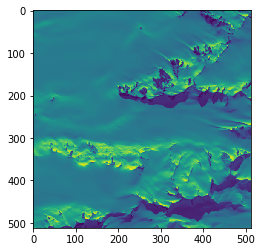

AttributeError: module 'rasterio.plot' has no attribute 'colorbar'

In [30]:
col_off = 10
row_off = 13
B2 = get_tile(thisTileFile + "_B2.TIF", col_off=col_off, row_off=row_off)


B3 = get_tile(thisTileFile + "_B3.TIF", col_off=col_off, row_off=row_off)

B4 = get_tile(thisTileFile + "_B4.TIF", col_off=col_off, row_off=row_off)

B5 = get_tile(thisTileFile + "_B5.TIF", col_off=col_off, row_off=row_off)

B6 = get_tile(thisTileFile + "_B6.TIF", col_off=col_off, row_off=row_off)

B10 = get_tile(thisTileFile + "_B10.TIF", col_off=col_off, row_off=row_off)

rplt.show(B2)
rplt.show(B3)
rplt.show(B5)
rplt.show(B6)
rplt.show(B10)

Create normalized versions of bands to display full color image

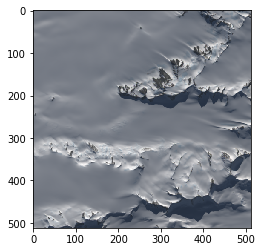

In [10]:
B2_norm = (B2 * (255.0/ B2.max())).astype(int)
B3_norm = (B3 * (255.0/ B3.max())).astype(int)
B4_norm = (B4 * (255.0/ B4.max())).astype(int)
full_color = np.dstack((B4_norm, B3_norm, B2_norm))
plt.imshow(full_color)

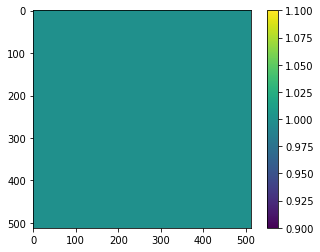

In [11]:
# The example tile is landlocked. skipping coastline mask for now
coastMaskBin = (B2 > 0).astype(int)

plt.imshow(coastMaskBin.squeeze())
plt.colorbar()

In [12]:
toc = time.time()
print(" Loaded & Coast Masked (%.02fs)." % (toc - tic))
tic = time.time()

 Loaded & Coast Masked (1.94s).


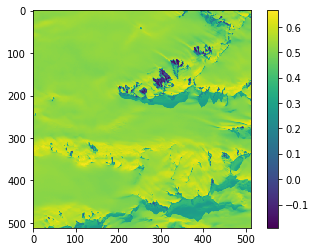

In [13]:
ndsi = (B3 - B6) / (B3 + B6)
plt.imshow(ndsi.squeeze())
plt.colorbar()

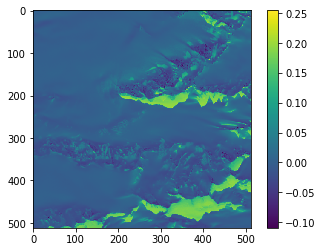

In [14]:
ndwi = (B3 - B5) / (B3 + B5)
plt.imshow(ndwi.squeeze())
plt.colorbar()

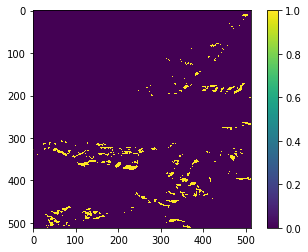

In [15]:
mask1_step1 = 1 - ((B10 / B2) > 0.4).astype(int)

plt.imshow(mask1_step1.squeeze())
plt.colorbar()

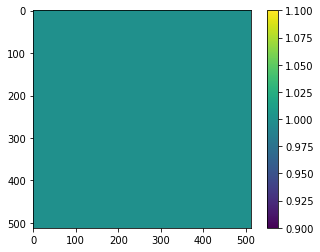

In [16]:
mask1_step2 = (ndsi < 0.75).astype(int)
plt.imshow(mask1_step2.squeeze())
plt.colorbar()

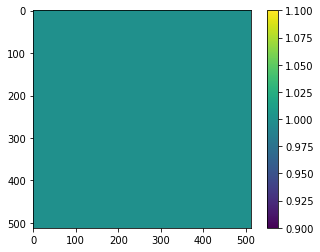

In [17]:
mask1_step3 = (ndwi < 0.45).astype(int)
plt.imshow(mask1_step3.squeeze())
plt.colorbar()

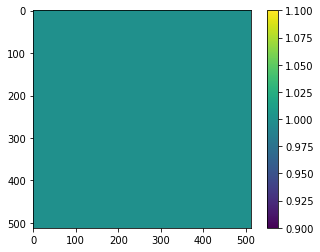

In [18]:
mask1_step5 = (B10 > 2550).astype(int) # Note: this is a scaled value
plt.imshow(mask1_step5.squeeze())
plt.colorbar()

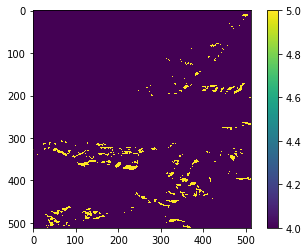

In [19]:
mask1_prefinal = mask1_step1 + mask1_step2 + mask1_step3 + coastMaskBin + mask1_step5

plt.imshow(mask1_prefinal.squeeze())
plt.colorbar()

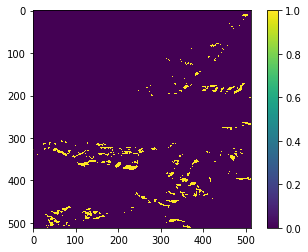

In [20]:
mask1_final = (mask1_prefinal == 5).astype(int)
plt.imshow(mask1_final.squeeze())
plt.colorbar()

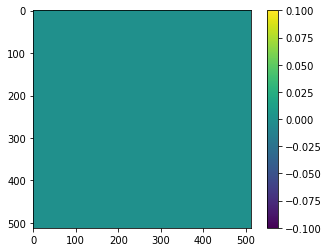

In [21]:
mask2_step1 = (B2 < 2500.0).astype(int) # note this is a scaled value
plt.imshow(mask2_step1.squeeze())
plt.colorbar()

0.25445904389152924


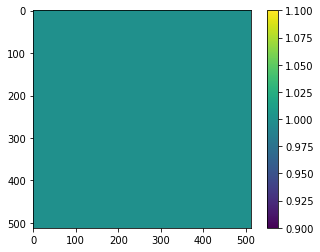

In [22]:
mask2_step2 = (ndwi < 0.45).astype(int)
plt.imshow(mask2_step2.squeeze())
plt.colorbar()
print(ndwi.max())

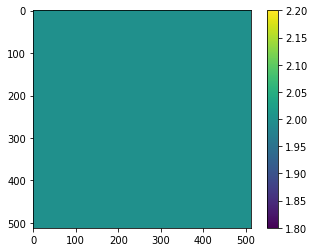

In [23]:
mask2_prefinal = mask2_step1 + mask2_step2 + coastMaskBin
plt.imshow(mask2_prefinal.squeeze())
plt.colorbar()

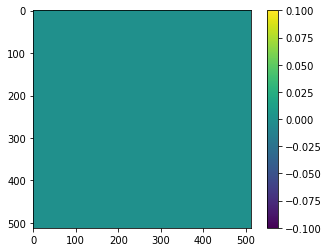

In [24]:
mask2_final = (mask2_prefinal == 3).astype(int)
plt.imshow(mask2_final.squeeze())
plt.colorbar()

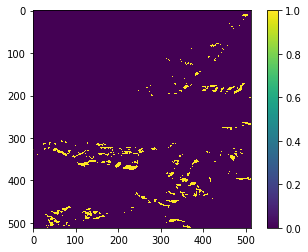

In [25]:
mask_prefinal = mask1_final + mask2_final
plt.imshow(mask_prefinal.squeeze())
plt.colorbar()

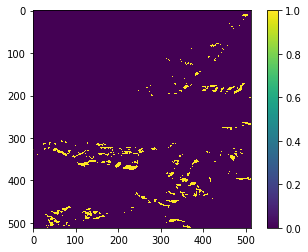

In [26]:
mask_final = (mask_prefinal > 0).astype(int)
plt.imshow(mask_final.squeeze())
plt.colorbar()

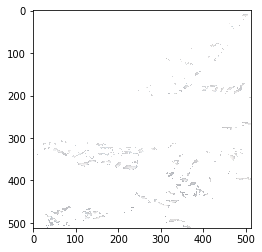

In [29]:
mask_final_norm = mask_final * 255
full_color_masked = np.dstack((B4_norm, B3_norm, B2_norm, mask_final_norm))
plt.imshow(full_color_masked)